In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import sklearn as sk
from sklearn import neighbors
import preprocessing as pp
import utilities as u
from matplotlib import pyplot as plt
import pickle
import os
from scipy.interpolate import interp1d as spline
from sklearn.linear_model import HuberRegressor as hreg

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def gaussian(mu,sigma,x):
    '''radial basis function centered at 'mu' with width 'sigma', sampled at 'x' '''
    return np.exp(-(mu-x)**2/sigma**2)

getf = lambda s : s*2.5 + (1-s)*3.5
gettheta = lambda s: (s*60. + (1-s)*10.)*np.pi/180
xfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)-np.sin(gettheta(s)+np.pi/4.))) 
yfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)+np.sin(gettheta(s)+np.pi/4.))) 
ang = lambda x,y: np.arctan(x/y)*180/np.pi

wallmorphx = lambda s: 1.2*(xfreq(s)-xfreq(-.1))/(xfreq(1.1)-xfreq(-.1))-.1
wallmorphy = lambda s: 1.2*(yfreq(s)-yfreq(-.1))/(yfreq(1.1)-yfreq(-.1))-.1

In [3]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [4]:
# load sf regression info for priors
with open("D:\\Morph_Results\\rare_sf_regression.pkl",'rb') as f:
    rare_sfreg = pickle.load(f)
    
with open("D:\\Morph_Results\\freq_sf_regression.pkl",'rb') as f:
    freq_sfreg = pickle.load(f)

In [5]:
def mean_prior_post(dict_sfreg,sigma_likelihood=.3,x=np.linspace(-.1,1.1,num=1000)[np.newaxis,:]):
    mice = [mouse for mouse in dict_sfreg.keys()]
    priors = np.zeros([len(mice),x.shape[1]])
    for i, (mouse,res) in enumerate(dict_sfreg.items()):
        _prior=None
        for _p in res['priors']:
            if _prior is None:
                _prior = _p
            else:
                _prior+=_p
        _prior = _prior/_prior.sum()
        priors[i,:]=_prior
        
    prior = _prior.mean(axis=0,keepdims=True)
    prior = prior/prior.sum()
    post = prior*gaussian(np.linspace(-.11,1.11,num=1000)[:,np.newaxis],sigma_likelihood,np.linspace(-.3,1.3,num=1000)[np.newaxis,:])
    post = post/post.sum(axis=1)
    return priors, prior, post
rare_priors,rare_prior,rare_post = mean_prior_post(rare_sfreg)
freq_priors,freq_prior,freq_post = mean_prior_post(freq_sfreg)

In [6]:
def calculate_posterior(prior,morphs,xx_lims = (-.1,1.1)):
    xx = np.linspace(xx_lims[0],xx_lims[1],num=prior.size)
    post = prior*gaussian(wallmorphx(morphs[:,np.newaxis]),.3,xx[np.newaxis,:])
    post = post/post.sum(axis=1,keepdims=True)
    return post, xx

def make_sampling_spline(xx,prob):
    cum_prob = np.cumsum(prob)
    cum_prob[0],cum_prob[-1] = 0,1
    
    return spline(cum_prob,xx)

# sample from posterior
def simulate_trial(prior,morphs, n_neurons=100,n_samps=1,rbf_sigma=.4):
    post, xx = calculate_posterior(prior,morphs)
    neurons = np.zeros([morphs.shape[0],n_neurons*n_samps])
    _nn = np.linspace(-.1,1.1,num=n_neurons)
    for trial in range(post.shape[0]):
        samplingspline = make_sampling_spline(xx,post[trial,:])
#         cum_post_t = np.cumsum(post[trial,:])
#         cum_post_t[0],cum_post_t[-1] = 0,1
#         samplingspline  = spline(cum_post_t,xx)
        
        post_samples = samplingspline(np.random.rand(n_samps))
        for samp_i in range(post_samples.size): 
#             do = np.ones(_nn.shape)
#             do[np.random.permutation(_nn.size-1)[:250]]=0
            neurons[trial,n_neurons*samp_i:n_neurons*(samp_i+1)] = gaussian(_nn,rbf_sigma,post_samples[samp_i]) 
    
    simdata=np.random.gamma(neurons) + np.random.gamma(.5*np.random.rand(*neurons.shape))
    
    simdata_norm = simdata/np.linalg.norm(simdata,axis=1,ord=2,keepdims=True)

    simdata_sm = np.dot(simdata_norm,simdata_norm.T)
    trial_info = {}
    trial_info['morphs']=np.copy(morphs)
    trial_info['morphs'][morphs<.1]=0
    trial_info['morphs'][morphs>.9]=1
    sf = u.similarity_fraction(simdata,trial_info)
    
    return simdata, simdata_sm, sf

def simmat_distribution(morphs,n_neurons,prior,nperms=1000,rbf_sigma=.4):
    SIMDATA, SIMDATA_SM, SF = [],[],[]
    for it in range(nperms):
        if it%100 == 0:
            print(it)
        simdata,simdata_sm,sf = simulate_trial(prior,morphs,n_samps=1,n_neurons=n_neurons,rbf_sigma = rbf_sigma)
        SIMDATA.append(simdata)
        SIMDATA_SM.append(simdata_sm)
        SF.append(sf)
    return np.array(SIMDATA), np.array(SIMDATA_SM), np.array(SF)

def run_simmat_distributions(sess):
    with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
        data = pickle.load(f)
    
    S, tstart_inds, teleport_inds,VRDat = np.copy(data["S"]), data["tstart_inds"], data["teleport_inds"],data["VRDat"]
    S[np.isnan(S)]=0
    S = S/1546 #np.percentile(S,95,axis=0,keepdims=True)
    S_trial_mat = u.make_pos_bin_trial_matrices(np.copy(S),data['VRDat']['pos']._values,tstart_inds,
                                                teleport_inds,bin_size=10,mat_only=True)
    
    trial_info = data['trial_info']
    morphs = trial_info['morphs']+trial_info['wallJitter']
    morphsort = np.argsort(morphs)
    morphs = morphs[morphsort]

    S_trial_mat = S_trial_mat[morphsort,:,:]
    S_trial_mat = sp.ndimage.filters.gaussian_filter1d(S_trial_mat,2,axis=1)
    S_trial_mat[np.isnan(S_trial_mat)]=0
    S_tmat = S_trial_mat.reshape(S_trial_mat.shape[0],-1)
    S_tmat_norm = S_tmat/(np.linalg.norm(S_tmat,axis=1,ord=2,keepdims=True)+1E-8)
    
    
    SIMDATA,SIMDATA_SM,SIMDATA_SF = {},{},{}
    for prior,name in zip([rare_prior,freq_prior],['rare','freq']):
        print(name)
        sd,sdsm,sdsf = simmat_distribution(morphs,S_trial_mat.shape[-1],prior,nperms=1000)
        SIMDATA[name],SIMDATA_SM[name], SIMDATA_SF[name]= sd, sdsm,sdsf
    return morphs,S_trial_mat, np.dot(S_tmat_norm,S_tmat_norm.T), u.similarity_fraction(S_trial_mat,trial_info), SIMDATA, SIMDATA_SM, SIMDATA_SF

# Figures for schematic of how model works

0.0
0.3
0.6
0.8999999999999999
1000


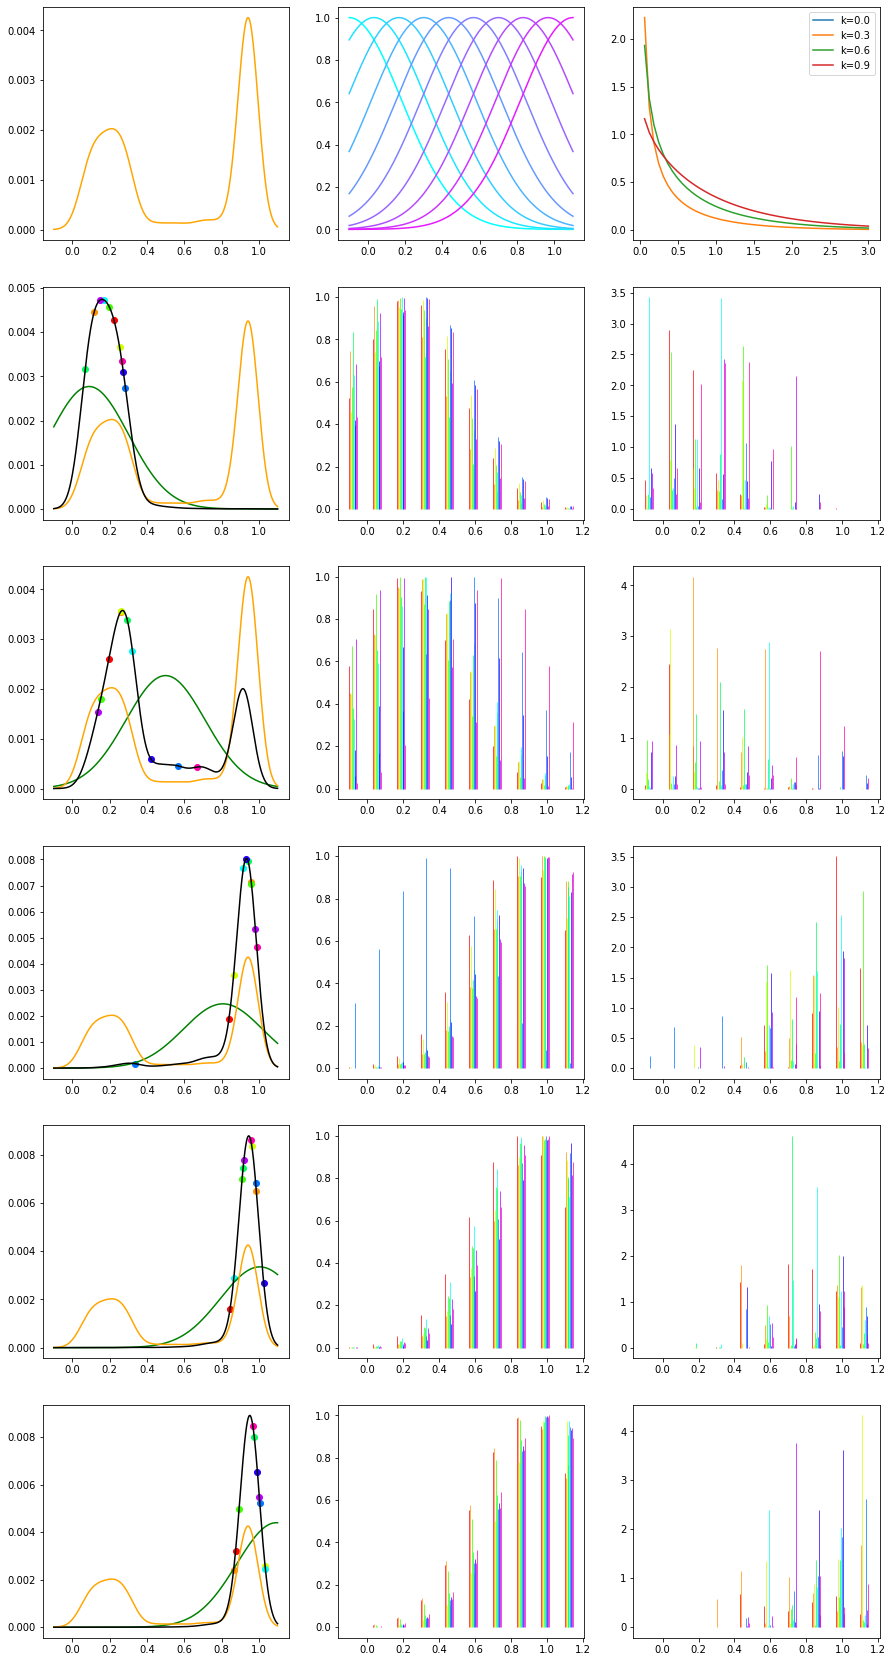

In [7]:
xx = np.linspace(-.1,1.1,num=rare_prior.size)
f,ax = plt.subplots(6,3,figsize=[15,30])


ax[0,0].plot(xx,rare_prior.ravel(),color='orange')
_x = np.linspace(0,3)
for alpha in np.arange(0,1,.3).tolist(): 
    print(alpha)
    ax[0,2].plot(_x,sp.stats.gamma.pdf(_x,alpha),label="k=%.1f" % alpha )
ax[0,2].legend()
    
# ax[0,1].plot(xx,freq_prior.ravel(),color='blue')
mus = np.linspace(-.1,1.1,num = 10)
for i, mu in enumerate(mus.tolist()):
    ax[0,1].plot(xx,gaussian(mu,.4,xx),color=plt.cm.cool(np.float(i)/10.))
shats= np.array([0, .25,.5,.75,1])
print(rare_prior.size)
post, xx = calculate_posterior(rare_prior,shats)
for j,shat in enumerate(shats.tolist()):
    l = gaussian(wallmorphx(shat),.3,xx)
    l = l/l.sum()
    ax[j+1,0].plot(xx,l,color='green')
    ax[j+1,0].plot(xx,rare_prior.ravel(),color='orange')
    
    ax[j+1,0].plot(xx,post[j,:],color='black')
    post_spline = spline(xx,post[j,:])
    
    
    # sample 3 times
    sampling_spline=make_sampling_spline(xx,post[j,:])
    eps = 5E-3
    for s in range(10):
        sample = sampling_spline(np.random.rand(1))
        ax[j+1,0].scatter(sample,post_spline(sample), c= np.array(plt.cm.hsv(s/10.))[np.newaxis,:])
        pop_tf = gaussian(mus,.4,sample)
#         print(pop_tf.shape)
        ax[j+1,1].vlines(mus+eps*s,0,pop_tf,color=plt.cm.hsv(s/10.),linewidths=.7)

        ax[j+1,2].vlines(mus+eps*s,0,np.random.gamma(pop_tf),color=plt.cm.hsv(s/10.),linewidth=.7)

    
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\schematic_figs.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\schematic_figs.png",format='png')

# Confirming that this model reproduces the posterior and superficially has the statistics of the real neural data

In [ ]:
# confirm that this gives back a representation of the posterior
linmorphs = np.linspace(-.1,1.1,num=100)
rare_post,xx = calculate_posterior(rare_prior,linmorphs,xx_lims = (-.1,1.1))
rare_simdat,rare_sm, rare_sf = simmat_distribution(linmorphs,1000,rare_prior,nperms=1000,rbf_sigma=.1)
rare_simdat_wide,rare_sm, rare_sf_wide = simmat_distribution(linmorphs,1000,rare_prior,nperms=1000,rbf_sigma=.4)

print(rare_simdat.shape)
map_estimate = xx[np.argmax(rare_post,axis=1)]
for p in range(100):
    linmodel = hreg().fit(rare_sf[p:p+1,:].T,map_estimate)
    rare_sf[p,:] = linmodel.predict(rare_sf[p:p+1,:].T)
    linmodel = hreg().fit(rare_sf_wide[p:p+1,:].T,map_estimate)
    rare_sf_wide[p,:] = linmodel.predict(rare_sf_wide[p:p+1,:].T)

0
100
200
300


In [ ]:
f,ax = plt.subplots(2,3,figsize=[15,10])
f.subplots_adjust(hspace=.3,wspace=.3)
ax[0,0].imshow(rare_post.T,cmap = 'RdPu',aspect='auto',vmin=np.percentile(rare_post,20),extent = [-.1,1.1,1.1,-.1])
ax[0,0].scatter(linmorphs,xx[np.argmax(rare_post,axis=1)],color='brown')
ax[0,0].set_ylabel("$ S $",fontsize=15)
ax[0,0].set_xlabel("$\hat{S}$",fontsize=15)
ax[0,0].set_title("$P(S|\hat{S})$",fontsize=20)



ax[1,0].imshow(np.log(rare_post.T),cmap = 'RdPu',aspect='auto',vmin=np.percentile(np.log(rare_post),20),extent = [-.1,1.1,1.1,-.1])
ax[1,0].scatter(linmorphs,xx[np.argmax(rare_post,axis=1)],color='brown')
ax[1,0].set_ylabel("$ S $",fontsize=15)
ax[1,0].set_xlabel("$\hat{S}$",fontsize=15)
ax[1,0].set_title("$log P(S|\hat{S})$",fontsize=20)


ax[0,1].imshow(rare_simdat.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(rare_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1])
ax[0,1].scatter(linmorphs,xx[np.argmax(rare_post,axis=1)],color='brown',zorder=10)
ax[0,1].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[0,1].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
ax[0,1].set_title("Average Neural Activity \n (1000 samples, $\sigma_{rbf}=.1$)",fontsize=20)

ax[1,1].imshow(rare_simdat.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(rare_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1])
ax[1,1].scatter(linmorphs,xx[np.argmax(rare_post,axis=1)],color='brown',zorder=10)
ax[1,1].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[1,1].set_xlabel("$\hat{S}$ / Trial morph value",fontsize=15)
for j in range(0,100,10):
    ax[1,1].scatter(linmorphs,rare_sf[j,:],zorder=1,color=plt.cm.copper(np.float(j)/100.),alpha=.3)

    
ax[0,2].imshow(rare_simdat_wide.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(rare_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1],zorder=0)
ax[0,2].scatter(linmorphs,xx[np.argmax(rare_post,axis=1)],color='brown',zorder=10)
ax[0,2].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[0,2].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
ax[0,2].set_title("Average Neural Activity \n (1000 samples, $\sigma_{rbf}=.4$)",fontsize=20)


ax[1,2].imshow(rare_simdat_wide.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(rare_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1],zorder=0)
ax[1,2].scatter(linmorphs,xx[np.argmax(rare_post,axis=1)],color='brown',zorder=10)
ax[1,2].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[1,2].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
# ax[3].scatter(linmorphs,rare_sf_wide.mean(axis=0))
for j in range(0,100,10):
    ax[1,2].scatter(linmorphs,rare_sf_wide[j,:],zorder=1,color=plt.cm.copper(np.float(j)/100.),alpha=.3)
    
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\rare_model_confirmation.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\rare_model_confirmation.png",format='png')

f,ax = plt.subplots(1,2,figsize=[10,5])
ax[0].plot(xx,rare_prior.ravel(),color='brown',linewidth=5)
ax[1].plot(xx,rare_prior.ravel(),color='brown',linewidth=5)
edges = np.linspace(-.1,1.1,num=20)
centers = (edges[:-1] + edges[1:])/2.
for j in range(0,100,10):
    _j_rare_sf_bins = np.mean(gaussian(rare_sf[j:j+1,:],.1,xx[:,np.newaxis]),axis=1)
    ax[0].plot(xx,_j_rare_sf_bins/_j_rare_sf_bins.sum(),color = plt.cm.copper(np.float(j)/100.),alpha=.3)
    _j_rare_sf_wide_bins = np.mean(gaussian(rare_sf_wide[j:j+1,:],.1,xx[:,np.newaxis]),axis=1)
    ax[1].plot(xx,_j_rare_sf_wide_bins/_j_rare_sf_wide_bins.sum(),color = plt.cm.copper(np.float(j)/100.),alpha=.3)
    
ax[0].set_xlabel("$S$",fontsize=15)
ax[1].set_xlabel("$S$",fontsize=15)

ax[0].set_ylabel("$P(S)$ / $P(SF)$",fontsize=15)
ax[1].set_ylabel("$P(S)$ / $P(SF)$",fontsize=15)


ax[0].set_title("$\sigma_{rbf}=.1$",fontsize = 20)
ax[1].set_title("$\sigma_{rbf}=.4$",fontsize = 20)

f.subplots_adjust(wspace=.3)
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\rare_model_marginal_hist.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\rare_model_marginal_hist.png",format='png')

In [ ]:
freq_post,xx = calculate_posterior(freq_prior,linmorphs,xx_lims = (-.1,1.1))
freq_simdat,freq_sm, freq_sf = simmat_distribution(linmorphs,1000,freq_prior,nperms=1000,rbf_sigma=.1)
freq_simdat_wide,freq_sm, freq_sf_wide = simmat_distribution(linmorphs,1000,freq_prior,nperms=1000,rbf_sigma=.4)


map_estimate = xx[np.argmax(freq_post,axis=1)]
for p in range(100):
    linmodel = hreg().fit(freq_sf[p:p+1,:].T,map_estimate)
    freq_sf[p,:] = linmodel.predict(freq_sf[p:p+1,:].T)
    linmodel = hreg().fit(freq_sf_wide[p:p+1,:].T,map_estimate)
    freq_sf_wide[p,:] = linmodel.predict(freq_sf_wide[p:p+1,:].T)

In [ ]:
f,ax = plt.subplots(2,4,figsize=[20,10])
f.subplots_adjust(hspace=.3,wspace=.3)
ax[0,0].imshow(freq_post.T,cmap = 'RdPu',aspect='auto',vmin=np.percentile(freq_post,20),extent = [-.1,1.1,1.1,-.1])
ax[0,0].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue')
ax[0,0].set_ylabel("$ S $",fontsize=15)
ax[0,0].set_xlabel("$\hat{S}$",fontsize=15)
ax[0,0].set_title("$P(S|\hat{S})$",fontsize=20)

ax[1,0].imshow(freq_post.T,cmap = 'RdPu',aspect='auto',vmin=np.percentile(freq_post,20),extent = [-.1,1.1,1.1,-.1])
ax[1,0].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue')
ax[1,0].set_ylabel("$ S $",fontsize=15)
ax[1,0].set_xlabel("$\hat{S}$",fontsize=15)


ax[0,1].imshow(np.log(freq_post.T),cmap = 'RdPu',aspect='auto',vmin=np.percentile(np.log(freq_post),20),extent = [-.1,1.1,1.1,-.1])
ax[0,1].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue')
ax[0,1].set_ylabel("$ S $",fontsize=15)
ax[0,1].set_xlabel("$\hat{S}$",fontsize=15)
ax[0,1].set_title("$log P(S|\hat{S})$",fontsize=20)
ax[1,1].imshow(np.log(freq_post.T),cmap = 'RdPu',aspect='auto',vmin=np.percentile(np.log(freq_post),20),extent = [-.1,1.1,1.1,-.1])
ax[1,1].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue')
ax[1,1].set_ylabel("$ S $",fontsize=15)
ax[1,1].set_xlabel("$\hat{S}$",fontsize=15)



ax[0,2].imshow(freq_simdat.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(freq_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1])
ax[0,2].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue',zorder=10)
ax[0,2].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[0,2].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
ax[0,2].set_title("Average Neural Activity \n (1000 samples, $\sigma_{rbf}=.1$)",fontsize=20)

ax[1,2].imshow(freq_simdat.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(freq_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1])
ax[1,2].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue',zorder=10)
ax[1,2].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[1,2].set_xlabel("$\hat{S}$ / Trial morph value",fontsize=15)
for j in range(0,100,10):
    ax[1,2].scatter(linmorphs,freq_sf[j,:],zorder=1,color=plt.cm.cividis(np.float(j)/100.),alpha=.3)

    
ax[0,3].imshow(freq_simdat_wide.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(freq_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1],zorder=0)
ax[0,3].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue',zorder=10)
ax[0,3].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[0,3].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
ax[0,3].set_title("Average Neural Activity \n (1000 samples, $\sigma_{rbf}=.4$)",fontsize=20)


ax[1,3].imshow(freq_simdat_wide.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(freq_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1],zorder=0)
ax[1,3].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue',zorder=10)
ax[1,3].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[1,3].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
# ax[3].scatter(linmorphs,rare_sf_wide.mean(axis=0))
for j in range(0,100,10):
    ax[1,3].scatter(linmorphs,freq_sf_wide[j,:],zorder=1,color=plt.cm.cividis(np.float(j)/100.),alpha=.3)
    
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\freq_model_confirmation.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\freq_model_confirmation.png",format='png')

f,ax = plt.subplots(1,2,figsize=[10,5])
ax[0].plot(xx,freq_prior.ravel(),color='blue',linewidth=5)
ax[1].plot(xx,freq_prior.ravel(),color='blue',linewidth=5)
edges = np.linspace(-.1,1.1,num=20)
centers = (edges[:-1] + edges[1:])/2.
for j in range(0,100,10):
    _j_freq_sf_bins = np.mean(gaussian(freq_sf[j:j+1,:],.1,xx[:,np.newaxis]),axis=1)
    ax[0].plot(xx,_j_freq_sf_bins/_j_freq_sf_bins.sum(),color = plt.cm.cividis(np.float(j)/100.),alpha=.3)
    _j_freq_sf_wide_bins = np.mean(gaussian(freq_sf_wide[j:j+1,:],.1,xx[:,np.newaxis]),axis=1)
    ax[1].plot(xx,_j_freq_sf_wide_bins/_j_freq_sf_wide_bins.sum(),color = plt.cm.cividis(np.float(j)/100.),alpha=.3)
    
ax[0].set_xlabel("$S$",fontsize=15)
ax[1].set_xlabel("$S$",fontsize=15)

ax[0].set_ylabel("$P(S)$ / $P(SF)$",fontsize=15)
ax[1].set_ylabel("$P(S)$ / $P(SF)$",fontsize=15)


ax[0].set_title("$\sigma_{rbf}=.1$",fontsize = 20)
ax[1].set_title("$\sigma_{rbf}=.4$",fontsize = 20)

f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\freq_model_marginal_hist.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\freq_model_marginal_hist.png",format='png')

f.subplots_adjust(wspace=.3)

# Run a set of simulated similarity matrices using parameters from a real session

- Choose number of neurons to match the number recorded in the session
- Choose the morph values to be the morph values seen in the session

- Uniformly randomly choose location of peak tuning for each neuron on each simulated session
- On each simulated session, randomly choose the number of samples the population will draw on each trial. (random integer [1-5] inclusive)
    - Samples are concatenated to form trial x trial population similarity matrices

In [260]:
# load example session data
mouse = '4139265.5'
df_mouse = df[df["MouseName"]==mouse]

sess = df_mouse.iloc[-1]

In [269]:
def simulate_session_plot_results(sess):
    morphs,S_trial_mat,simmat, sf, SIMDATA,SIMDATA_SM,SIMDATA_SF = run_simmat_distributions(sess)
    
    sessdir = os.path.join("D:\\Morph_Results\\figures\\TheoreticalSimMats\\","%s_%s_%i" % (sess["MouseName"],sess["DateFolder"],sess["SessionNumber"]))
    try:
        os.makedirs(sessdir)
    except:
        pass



    simmat_z = sp.stats.zscore(simmat.ravel())
    f,ax = plt.subplots(1,2,figsize=[10,5])
    ax[0].imshow(simmat,vmin=np.percentile(simmat,20),vmax=np.percentile(simmat,80),cmap='Greys')
    ax[1].scatter(morphs,sf)
    ax[1].set_xlabel('$\hat{S}$')
    ax[1].set_ylabel('SF')
    f.savefig(os.path.join(sessdir,"simmat.pdf"),format='pdf')


    simsimmat_rare_z = sp.stats.zscore(SIMDATA_SM['rare'].reshape(SIMDATA_SM['rare'].shape[0],-1),axis=-1)
    simsimmat_freq_z = sp.stats.zscore(SIMDATA_SM['freq'].reshape(SIMDATA_SM['freq'].shape[0],-1),axis=-1)
    corr_rare, corr_freq = np.dot(simsimmat_rare_z,simmat_z)/simmat_z.shape[0],np.dot(simsimmat_freq_z,simmat_z)/simmat_z.shape[0]
    t,p = sp.stats.ranksums(corr_rare,corr_freq)
    print(sess["MouseName"],sess["DateFolder"],t,p)

    with open(os.path.join(sessdir,'simresults.pkl'),'wb') as file:
        pickle.dump({'SIMDATA':SIMDATA,'SIMDATA_SM':SIMDATA_SM,'SIMDATA_SF':SIMDATA_SF,
                     'morphs':morphs,'corr_rare':corr_rare,'corr_freq':corr_freq},file)

    f,ax = plt.subplots()
    allcorrs = np.concatenate((corr_rare,corr_freq))
    edges = np.linspace(np.amin(allcorrs),np.amax(allcorrs),num=25)
    rare_bins,_ = np.histogram(corr_rare,bins=edges)
    freq_bins,_ = np.histogram(corr_freq,bins=edges)
    ax.fill_between(edges[1:],rare_bins,alpha=.3,color='orange')
    ax.fill_between(edges[1:],freq_bins,alpha=.3,color='blue')
    ax.set_xlabel('correlation')
    ax.set_ylabel('count')
    ax.set_title("RankSum test, K=%.3f, p=%.3f" %(t,p))

    f.savefig(os.path.join(sessdir,"corr_distributions.pdf"),format='pdf')


    f,ax = plt.subplots()
    ax.plot(edges[1:],np.cumsum(rare_bins)/1000,color='orange')
    ax.plot(edges[1:],np.cumsum(freq_bins)/1000,color='blue')
    f.savefig(os.path.join(sessdir,"corr_cumdistributions.pdf"),format='pdf')
    for name in ['rare', 'freq']:
        f,ax = plt.subplots(20,3,figsize=[15,100])
        for it in range(20):
            ax[it,0].imshow(SIMDATA[name][it,:,:],aspect='auto',cmap='pink')
            ax[it,0].set_xlabel('neuron index')
            ax[it,0].set_ylabel('trial (sorted)')
            ax[it,0].set_title('single cell activity')

            ax[it,1].imshow(SIMDATA_SM[name][it,:,:],vmin=np.percentile(SIMDATA_SM[name][it,:,:],20),vmax=np.percentile(SIMDATA_SM[name][it,:,:],80),cmap='Greys')
            ax[it,1].set_title('trial x trial similarity')

            ax[it,2].scatter(morphs,1-SIMDATA_SF[name][it,:])
            ax[it,2].set_ylabel("SF")
            ax[it,2].set_xlabel("morph value")
        f.savefig(os.path.join(sessdir,"%s_eg_simulations.pdf" % name),format='pdf')

rare
0
100
200
300
400
500
600
700
800
900
freq
0
100
200
300
400
500
600
700
800
900


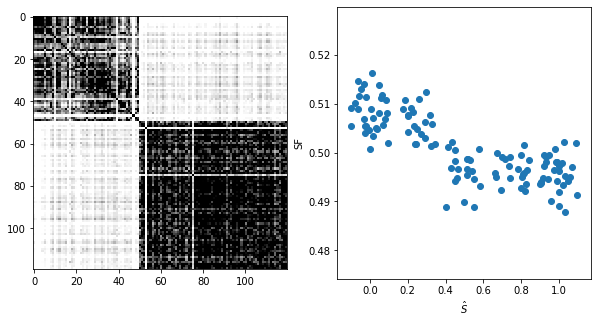

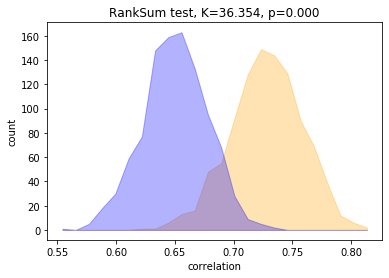

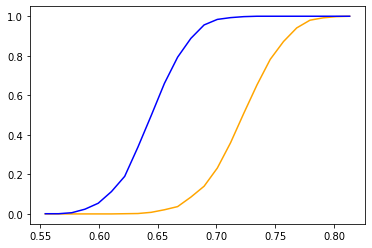

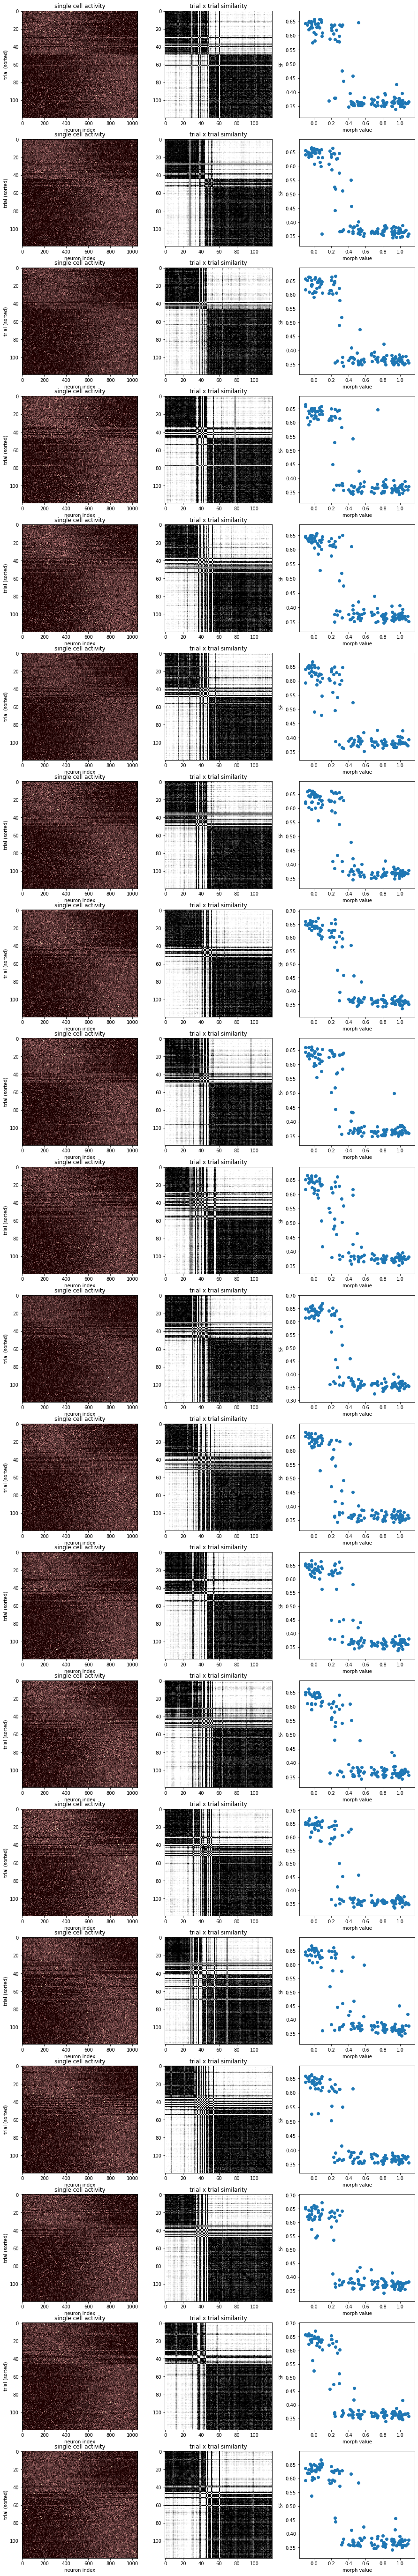

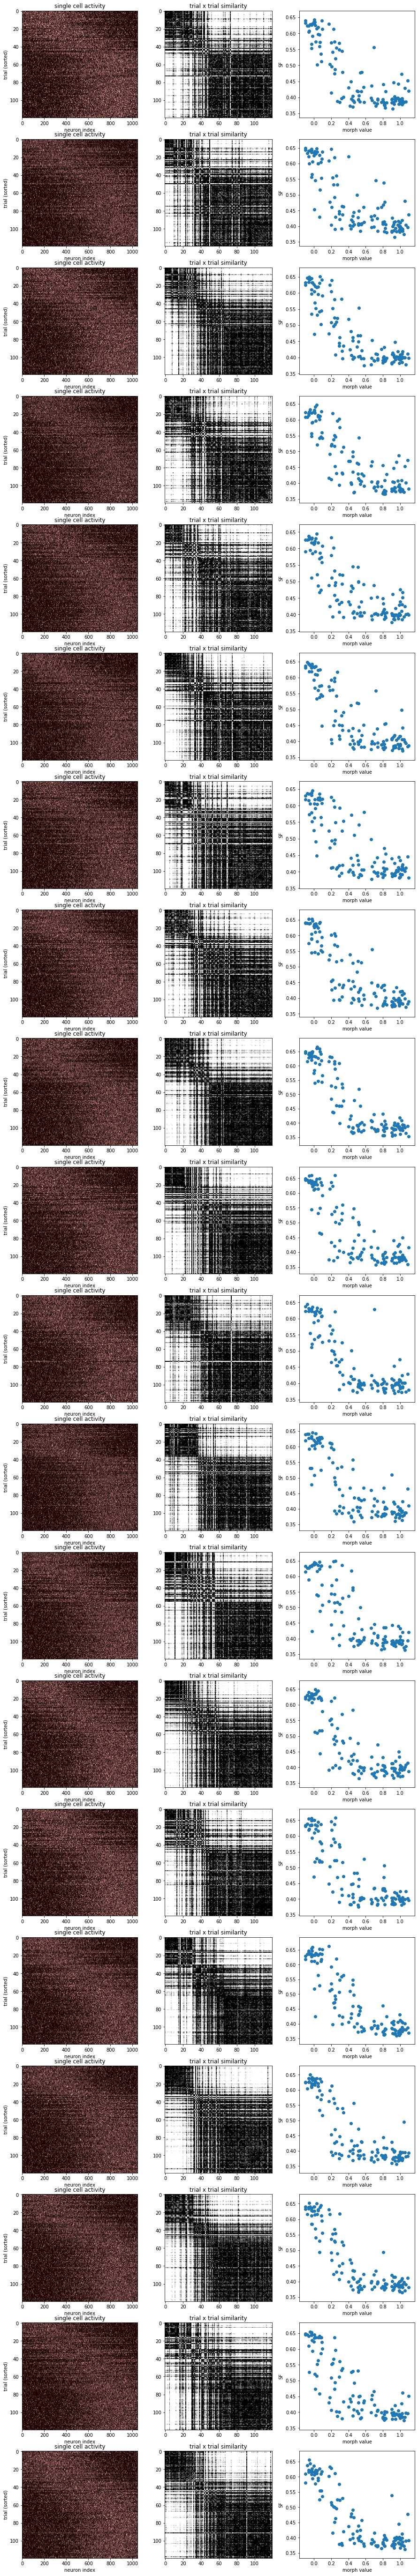